In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm
import seaborn as sns

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize
from functools import reduce

from sklearn.neighbors import KernelDensity
from sklearn.covariance import LedoitWolf

from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List, Tuple

# convex optimization 
import cvxpy as cp

"""
Own packages
"""

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# The covariance and correlation matrix 

As we previously have discussed covariance and correlation measure the linear dependence between stochastic variables. The [__covariance matrix__](https://en.wikipedia.org/wiki/Covariance_matrix) is a square matrix giving the covariance between each pair of elements of a given random vector. If we consider a $N$ dimensional random vector, $\mathbf{X}$, then the $N \times N$ matrix is a covariance matrix if 

* The matrix is symmetric
* The matrix has the variances in the diagonal
* The eigenvalues of the matrix are all non-negative (the matrix is positive semi-definite)

We will write 

$$
\boldsymbol{\Sigma} = \text{Var} [\mathbf {X} ]= \text{Cov} [\mathbf {X} ]=\text {E} \left[(\mathbf {X} -\text {E} [\mathbf {X} ])(\mathbf {X} -\text {E} [\mathbf {X} ])^\top \right]
$$


The last condition implies that the variance of any linear combination of $\mathbf{X}$, say $\mathbf{a}\mathbf{X}$, always will be larger than (or equal to) zero since 

$$
\text{Var}[\mathbf{a}  \mathbf {X} ] = \mathbf{a}^\top \text{Var}[\mathbf {X} ] \mathbf{a} \geq 0
$$

The [__correlation matrix__](https://en.wikipedia.org/wiki/Correlation#Correlation_matrices) constains the correlations instead of the covariances and satisfies the conditions

* The matrix is symmetric
* The matrix has ones in the diagonal
* The eigenvalues of the matrix are all non-negative (the matrix is positive semi-definite)


## The sample covariance and correlation matrix

Generally, the covariance and correlation matrix of some random vector are unobserved. Thus, we need to replace them with consistent estimators. 

If we let $\mathbf{X}$ be $T \times N$ matrix of $T$ independent and identically distributed (iid) observations on a system of $N$ random variables with zero mean (demeaned data) and covariance matrix $\boldsymbol{\Sigma}$

$$
\mathbf{S}_T = \frac{1}{T}\mathbf{X}^\top \mathbf{X}
$$

If $\mathbf{X}$ does not have zero mean, we need to estimate the mean and demean the data

$$
\mathbf{S}_T = \frac{1}{T}(\mathbf{X} - \bar{\mathbf{X}})^\top (\mathbf{X} - \bar{\mathbf{X}})
$$

The problem with the sample covariance estimator is that many applications in finance (e.g. portfolio optimization) require an invertible and well-conditioned covariance matrix (inversion does not increase estimation error). However, the sample covariance matrix is typically not well-conditioned and may in some case not even be invertible. This problem is in particular relevant when $N$ is large compared to $T$. 

## Thinking about the uncertainty of the sample covariance and correlation matrix

Assume that the random vector $\mathbf{X} \sim MVN(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ follows a i.i.d. multivariate normal distribution. In this case, it is possible to show that conditional distribution of the sample mean $\bar{\mathbf{X}}$ is given by 

$$
\bar{\mathbf{X}} = \frac{1}{T} \sum_{t=1}^T \mathbf{X}_t \sim MVN(\boldsymbol{\mu}, \frac{1}{T} \boldsymbol{\Sigma})
$$

and it is possible to show that the conditional distribution of the sample covariance is given by 

$$
\mathbf{S}_T \sim Wishart(T-1, \frac{1}{T}\Sigma)
$$

__Example: The case $N=1$__

In the univariate case, we obtain the special case

$$
\bar{\mathbf{X}} \sim N(\mu, \frac{\sigma^2}{T})
$$

and 

$$
\mathbf{S}_T \sim Wishart(T-1, \frac{\sigma^2}{T})
$$

which is equivalent to 

$$
T\frac{\mathbf{S}_T}{\sigma^2} \sim \chi^2_{T-1}
$$

In [2]:
sigma = 0.15
mu = 0.06
T = 100
num_sim = 10000

m_eval = np.linspace(0.0, 0.12, 1000)
s_eval = np.linspace(0.00001, 0.05, 1000)

# sim_sample_mean = stats.norm.rvs(loc=mu, scale=sigma / np.sqrt(T), size=num_sim)
# sim_sample_variance = stats.wishart.rvs(df=T-1, scale=sigma**2 / T, size=num_sim)

# simulate data
sim_data = stats.norm.rvs(mu, sigma, size=(num_sim, T))

# estimate sample mean and variance
sim_sample_mean = np.mean(sim_data, axis=1)
sim_sample_variance = np.var(sim_data, axis=1, ddof=0)

# calculate pdf values
pdf_sample_mean = stats.norm.pdf(m_eval, loc=mu, scale=sigma / np.sqrt(T))
pdf_sample_variance = stats.wishart.pdf(s_eval, df=T-1, scale=sigma**2 / T)

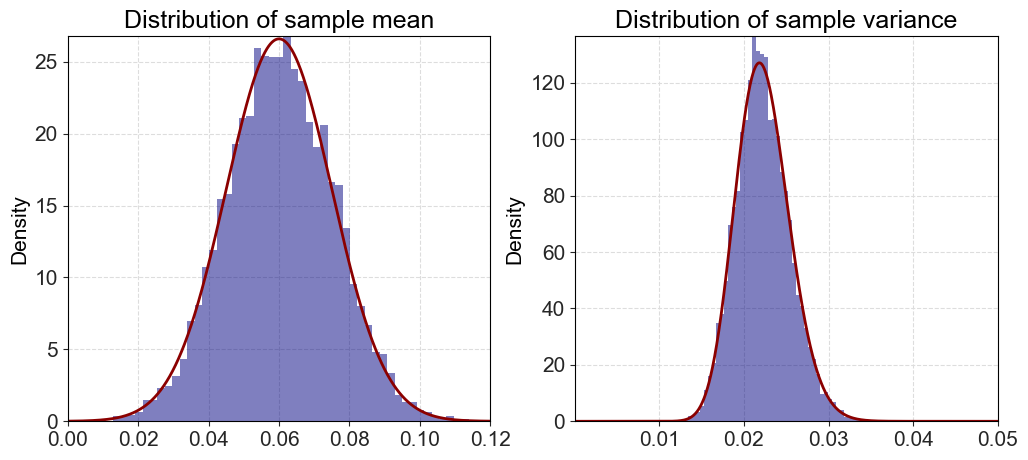

In [3]:
"""
Sample distribution 
"""

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax = ax.flatten()

ax[0].hist(sim_sample_mean, alpha=0.5, color="navy", bins=50, density=True)
ax[0].plot(m_eval, pdf_sample_mean, color="darkred")
ax[0].set(ylabel="Density", title="Distribution of sample mean")


ax[1].hist(sim_sample_variance, alpha=0.5, color="navy", bins=50, density=True)
ax[1].plot(s_eval, pdf_sample_variance, color="darkred")
ax[1].set(ylabel="Density", title="Distribution of sample variance");

__Example: Simulating distribution of the minimum-variance portfolio__

Assume that the monthly return of 10 assets follows a multivariate normal distribution 

$$
\boldsymbol{R} \sim MVN(\mathbf{0}, \mathbf{I}_{10} \cdot 0.05^2)
$$

Thus, all assets are uncorrelated with standard devation $\sigma_i = 0.05, i = 1, ..., 10$. 

We want to simulate the sample covariance and determine the corresponding minimum-variance portfolio for 10000 simulations assuming a estimation window of 120 months. Thereafter, we want to plot the simulated distribution of the minimum-variance portfolio weights. 

Note that the the global minimum variance portfolio is the solution to the optimization problem 

$$
\mathbf{w}_{\text{GMV}} = \underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint and positivity constriants

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
w_i &\geq 0, \; i=1,..., N
\end{align}
$$

We know that the optimal portfolio, knowing the true covariance matrix, is an equal weighted portfolio. 

In [4]:
"""
Define inputs
"""

T = 120
num_assets = 10 
num_sim = 1000
cov_mat_true = np.eye(num_assets) * 0.05**2

In [5]:
# optimization variable 
w = cp.Variable(num_assets)

# define constraints 
constraints = [w >= 0]
constraints.append(cp.sum(w) == 1)

"""
Simulation and optimization 
"""

opt_ports = []

for i in range(num_sim): 
    
    # simulate covariance matrix
    cov_mat = stats.wishart.rvs(df=T-1, scale= cov_mat_true / T, size=1)
    
    # define problem 
    variance = cp.quad_form(w, cov_mat, assume_PSD=True)
    prob =  cp.Problem(cp.Minimize(variance), constraints)
    
    # solve problem
    prob.solve()
    
    # store values
    opt_ports.append(w.value)

# transform to numpy array
opt_ports = np.array(opt_ports)

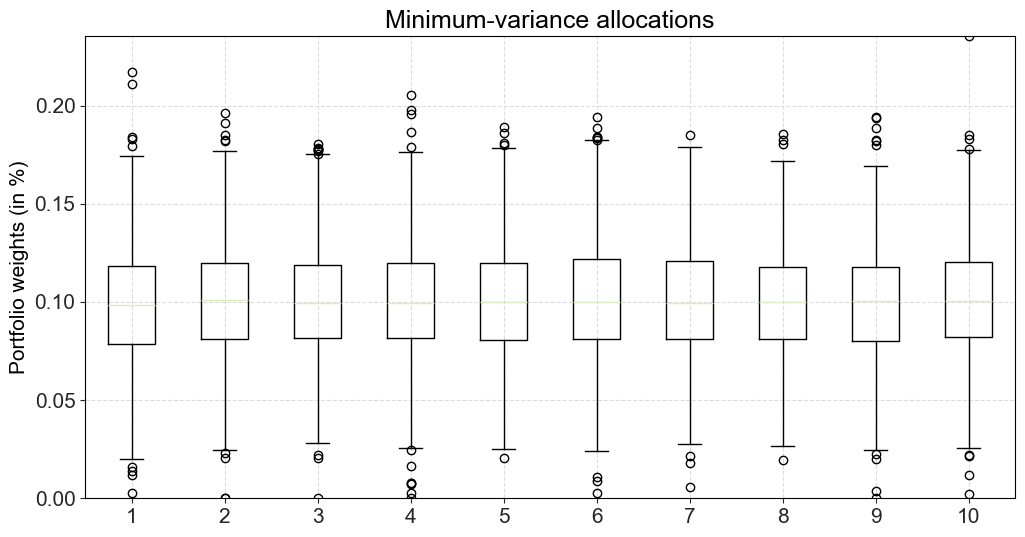

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(opt_ports);
ax.set(ylabel="Portfolio weights (in %)", title="Minimum-variance allocations");

This example show that it can be hard to find an optimal portfolio when relying on sample estimates!

## Fixing the covariance and correlation matrix 

We require that the covariance (and correlation) matrix is positive semi-definite corresponding to all the eigenvalues being non-negative. Thus, we could implement a check for positive semi-definiteness as 

In [7]:
def check_positive_semi_definite_eig(matrix: np.ndarray): 
    
    """
    Checks that a symmetric square matrix is positive semi-deinite. 
    
    Parameters
    ----------
    
    matrix: 
        Symmetric, Square matrix. 
        
    
    Returns
    -------
    bool
        Boolean indicating whether the matrix is positive semi-definite
        
    """
    
    return np.all(np.linalg.eigvals(matrix) >= 0)



In [8]:
# a positive semi-definite matrix
cov_mat = np.array([[0.01, 0.01],
                   [0.01, 0.01]])

check_positive_semi_definite_eig(cov_mat)

True

In [9]:
# a non positive semi-definite matrix
not_a_cov_mat = np.array([[0.01, 0.01],
                         [0.01, -0.01]])

check_positive_semi_definite_eig(not_a_cov_mat)

False

A computationally more efficient approach is to use

In [10]:
def check_positive_semi_definite(matrix: np.ndarray): 
    
    """
    Checks that a symmetric square matrix is positive semi-deinite. 
    
    See https://stackoverflow.com/questions/16266720/find-out-if-matrix-is-positive-definite-with-numpy
    
    Parameters
    ----------
    
    matrix: 
        Symmetric, Square matrix. 
        
    
    Returns
    -------
    bool
        Boolean indicating whether the matrix is positive semi-definite
        
    """
    
    try:
        np.linalg.cholesky(matrix + 1e-16 * np.eye(len(matrix)))
        return True
    except np.linalg.LinAlgError:
        return False

In [11]:
# a positive semi-definite matrix
cov_mat = np.array([[0.01, 0.01],
                    [0.01, 0.01]])

check_positive_semi_definite(cov_mat)

True

In [12]:
# a non positive semi-definite matrix
not_a_cov_mat = np.array([[0.01, 0.01],
                         [0.01, -0.01]])

check_positive_semi_definite(not_a_cov_mat)

False

In [13]:
"""
Checking performance - second method much quicker
"""

N = 1000

# set random seed 
np.random.seed(0)

# simulate a random covariance matrix
x = np.random.normal(size=(N))
cov_true = np.outer(x, x) + np.diag(0.01 + np.ones_like(x))

In [14]:
%timeit check_positive_semi_definite_eig(cov_true)

227 ms ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit check_positive_semi_definite(cov_true)

14.8 ms ± 978 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Spectral decomposition

If we conclude that the estimated (or assumed) covariance matrix is not positive semi-definite, we need to fix it somehow. There exists a large literature on this topic. 

[Rebonato and Jaeckel](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1969689) consider for instance _spectral decomposition_. The idea is to notice that every positive semi-definite matrix can be written as (here the covariance matrix)

$$
\boldsymbol{\Sigma} = \mathbf{A} \mathbf{A}^\top
$$

The characteristic equation defining the eigenvalues

$$
\boldsymbol{\Sigma} \mathbf{V} = \boldsymbol{\Lambda} \mathbf{V}
$$

where $\mathbf{V}$ is the matrix of eigenvectors and $\boldsymbol{\Lambda}$ is a diagonal matrix of eigenvalues. If $\boldsymbol{\Lambda}$ contains negative eigenvalues, we may simple set them equal to zero or some small positive number. We label this new matrix for $\boldsymbol{\Lambda}^*$. 

Define 

$$
\mathbf{A}^* = \mathbf{V} \sqrt{\boldsymbol{\Lambda}^*}
$$

such that we can define 

$$
\boldsymbol{\Sigma}^* = \mathbf{A}^* (\mathbf{A}^*)^\top
$$

If we are looking at the correlation matrix where we need the diagonal elements to all be equal to one, we can define 

$$
\mathbf{A}^* = \sqrt{\mathbf{T}} \mathbf{V} \sqrt{\boldsymbol{\Lambda}^*}
$$

where $\mathbf{T}$ is a diagonal matrix with elements equal to $t_i  = \left[\sum_{n=1}^N v_{in}^2 \lambda_i^*\right]^{-1}$. 

In [16]:
def fix_nonpositive_semidefinite(matrix: np.ndarray, method="spectral", scale_diag=False):
    
    # Eigendecomposition
    q, V = np.linalg.eigh(matrix)

    if method == "spectral":
        # Remove negative eigenvalues
        q = np.where(q > 0, q, 0)
        
        if scale_diag:
            
            # scaling matrix 
            scale_diag_mat = np.diag(1.0 / (V**2 @ q))

            # scaled eigenvector
            V = np.sqrt(scale_diag_mat) @ V
        
        # Reconstruct matrix
        fixed_matrix = V @ np.diag(q) @ V.T
        
    elif method == "diag":
        
        min_eig = np.min(q)
        fixed_matrix = matrix - 1.1 * min_eig * np.eye(len(matrix))
        
        if scale_diag:
            sqrt_diag = np.sqrt(np.diag(fixed_matrix))
            fixed_matrix = fixed_matrix / np.outer(sqrt_diag, sqrt_diag)
            fixed_matrix[fixed_matrix < -1], fixed_matrix[fixed_matrix > 1] = -1, 1
    
    else:
        raise NotImplementedError("Method not implemented")
        
    return fixed_matrix

In [17]:
"""
Positive semi-definite
"""

C = np.array([[1.0, 0.9, 0.7],
              [0.9, 1.0, 0.4],
              [0.7, 0.4, 1.0]])

q, V = np.linalg.eigh(C)
A = V @ np.sqrt(np.diag(q))
A
q

array([0.03034736, 0.6160166 , 2.35363603])

In [18]:
"""
Small change may result in the matrix no longer being a correlation / covariance matrix
"""

C_bad = np.array([[1.0, 0.9, 0.7],
                  [0.9, 1.0, 0.3],
                  [0.7, 0.3, 1.0]])

q, V = np.linalg.eigh(C_bad)
#A = V @ np.sqrt(np.diag(q)) <- throws an error 
#A

q # <- negative eigenvalue

array([-0.00735244,  0.71062465,  2.29672779])

In [19]:
C_fixed = fix_nonpositive_semidefinite(C_bad, scale_diag=True)
C_fixed

array([[1.        , 0.89402441, 0.69631907],
       [0.89402441, 1.        , 0.30096904],
       [0.69631907, 0.30096904, 1.        ]])

In [20]:
q_fixed, V_fixed = np.linalg.eigh(C_fixed)
q_fixed

array([-1.56125113e-16,  7.09606272e-01,  2.29039373e+00])

### Find the nearest covariance or correlation matrix by minimizing the Frobenius norm

We could consider an optimization problem of the form 

$$
\min \frac{1}{2} \Vert \mathbf{G} - \mathbf{X} \Vert^2
$$

subject to 

$$
\mathbf{X}_{ii} = 1, \; i = 1, ..., n
$$

and 

$$
\mathbf{X} \in \mathcal{S}^n
$$

Thus, $\mathbf{X}$ is a symmetric, positive definite matrix. 

It is possible to show that one can reformulate the problem as a semidefinite program or second-order program - we will just use `cvxpy` to define the problem. It should be noted that for large correlation matrices ($n$ large), then it would be infeasible to solve the problem using standard methods.   

In [21]:
"""
Define a bad correlation target matrix
"""
corr_mat_target = np.array([[1.0, 0.9, 0.7],
                           [0.9, 1.0, 0.3],
                           [0.7, 0.3, 1.0]])

check_positive_semi_definite(corr_mat_target)

False

In [22]:
"""
Fix the correlation matrix
"""

X = cp.Variable((3, 3), symmetric=True)

constraints = [X>>0]
for i in range(3): 
    constraints.append(X[i, i] ==1)

prob = cp.Problem(cp.Minimize(0.5*cp.norm2(X - corr_mat_target)),
                  constraints=constraints)

In [23]:
prob.is_dcp()

True

In [24]:
prob.solve()

0.003702316745665563

In [25]:
"""
Fixed correlation matrix
"""

X.value

array([[1.        , 0.89372048, 0.69607627],
       [0.89372048, 1.        , 0.29999991],
       [0.69607627, 0.29999991, 1.        ]])

In [26]:
check_positive_semi_definite(X.value)

True

### Other approaches 

For more advanced approaches the reader is referred to e.g. [Higham (2002), Computing the Nearest Correlation Matrix—
A Problem from Finance](http://eprints.maths.manchester.ac.uk/232/1/paper3.pdf). See also [here](https://nhigham.com/2013/02/13/the-nearest-correlation-matrix/).

## Shrinkage estimation 

As already mentioned, if the sample size, $T$, is small compared to the number of variables (e.g. assets), the sample covariance / correlation estimator may be very unstable. If $T<N$, then the estimated covariance matrix is singular. 

In [27]:
cov_mat = np.array([[1.0, 0.9, 0.7],
                    [0.9, 1.0, 0.4],
                    [0.7, 0.4, 1.0]])

sim_data = np.random.multivariate_normal(np.zeros(3), cov_mat, size=2)
np.linalg.eigvals(np.cov(sim_data, rowvar=False))

array([-5.55111512e-17,  3.81506063e-01,  1.09338007e-19])

In [28]:
# We will get an error message if we run the below command
# np.linalg.inv(np.cov(sim_data, rowvar=False))

In [29]:
cov_mat = np.array([[1.0, 0.9, 0.7],
                    [0.9, 1.0, 0.4],
                    [0.7, 0.4, 1.0]])

sim_data = np.random.multivariate_normal(np.zeros(3), cov_mat, size=5)
np.linalg.eigvals(np.cov(sim_data, rowvar=False))

array([1.2593379 , 0.0280332 , 0.51505968])

In many finance applications the sample size may be small relative the number of variables (think of 10 years of monthly return observations and 100 assets), why we need better estimators for the covariance matrix. 

A number of alternative covariance estimators has been suggested that rely on the concept of shrinkage. The simplest versions of the shrinkage estimators is defined by the convex combination of an empirical covariance matrix $\mathbf{S}_T$ (the sample covariance) and some suitable shrinkage target, say $\mathbf{B}$. The estimator will then be defined as 

$$
\delta \mathbf{S}_T + (1-\delta) \mathbf{B}
$$

where the parameter $\delta$ (shrinkage intensity) determines the relative weight of the empirical covariance and the shrinkage target. The shrinkage intensity will typically converge to zero with the sample size such that asymptotically, we will have the consistent estimator. The shrinkage estimator will always be positive definite and well conditioned!

A number of shrinkage targets has been [suggested](https://en.wikipedia.org/wiki/Estimation_of_covariance_matrices)

* The identity matrix scaled by the average sample variance
* The single index model
* The constant correlation model (all pairwise correlations are assumed equal)
* The two-parameter matrix (all variances and all covariances are equal)
* The diagonal matrix containing the sample variances on the diagonal and zeros elsewhere
* The identity matrix

We will look at one example of how to implement a shrinkage estimator. The `scikit-learn` package contains different shrinkage estimators. See [here](https://scikit-learn.org/stable/modules/covariance.html) for documentation. 

### Ledoit and Wolf (2004)

[Ledoit and Wolf (2004)](https://www.sciencedirect.com/science/article/pii/S0047259X03000964) define a shrinkage estimator for the covariance matrix

$$
\boldsymbol{\Sigma}^* = \rho_1 \mathbf{I} + \rho_2 \mathbf{S}
$$

with $\mathbf{S} = \frac{1}{T}\mathbf{X}^\top \mathbf{X} $ (the sample covariance) where $\mathbf{X}$ is $T \times N$ matrix of $T$ independent and identically distributed (iid) observations on a system of $N$ random variables with zero mean (demeaned data) and covariance matrix $\boldsymbol{\Sigma}$.

[Ledoit and Wolf (2004)](https://www.sciencedirect.com/science/article/pii/S0047259X03000964) show (when defining the Frobenius norm $\Vert \mathbf{A} \Vert = \sqrt{\text{tr} (\mathbf{A}\mathbf{A}^\top) / N} $ ) that the optimal values of $\rho_1$ and $\rho_2$ are given by

$$
\boldsymbol{\Sigma}^* = \frac{\beta^2}{\delta^2} \mu \mathbf{I} + \frac{\alpha^2}{\delta^2} \mathbf{S}
$$

with 

\begin{align}
\mu &= \frac{1}{N}\text{tr} (\boldsymbol{\Sigma}) \\
\alpha^2 &= \Vert \boldsymbol{\Sigma} - \mu \mathbf{I} \Vert \\
\beta^2 & = \text{E} \left[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert^2 \right]\\
\delta^2 & = \text{E} \left[\Vert \mathbf{S} - \mu \mathbf{I} \Vert^2 \right]
\end{align}


The problem with the above estimator is that it relies on the unobserved covariance matrix $\boldsymbol{\Sigma}$. We do not need to consistently estimate $\boldsymbol{\Sigma}$, but only find consistent estimators for $\mu, \alpha^2, \beta^2$ and $\delta^2$. To this end, we define a consistent estimator for $\mu$ as the sample counterpart (we add $_T$ to denote that the estimator depends on the sample length)

\begin{align}
m_T &= \frac{1}{N}\text{tr} (\mathbf{S}_T)
\end{align}

A consistent estimator of $\delta^2  = \text{E} \left[\Vert \mathbf{S} - \mu \mathbf{I} \Vert^2 \right]$ is also the sample counterpart 

$$
d_T^2 = \Vert \mathbf{S}_T  - \mu \mathbf{I} \Vert^2
$$

We can write 

$$
\mathbf{S}_T = \frac{1}{T}\mathbf{X}^\top \mathbf{X} = \frac{1}{T} \sum_{t=1}^T \mathbf{x}_t \mathbf{x}_t^\top
$$

where $\mathbf{x}$ is the $N \times 1$ vector representing the $t$'th row of $\mathbf{X}$. Since, we assume independence between $t$'s then we can use the deviations from the average. [Ledoit and Wolf (2004)](https://www.sciencedirect.com/science/article/pii/S0047259X03000964) suggest to define

$$
\bar{b}_T^2 = \frac{1}{T^2} \sum_{t=1}^T \Vert \mathbf{x}_t \mathbf{x}_t^\top - \mathbf{S}_T \Vert^2
$$

and  $b_T^2 = \min (\bar{b}_T^2, d_T^2)$. Finally, $a_T^2 = d_T^2 - b_T^2$.

We can now estimate 

$$
\mathbf{S}_T^* = \frac{b_T^2}{d_T^2} m_T \mathbf{I} + \frac{a_T^2}{d_T^2} \mathbf{S}_T
$$

In [30]:
def ledoit_wolf_shrinkage(data: np.ndarray, demean=True): 
    
    """
    Computes the Ledoit and Wolf (2004) shrinkage covariance matrix 
    
    See https://www.sciencedirect.com/science/article/pii/S0047259X03000964
    
    Parameters
    ----------
    data:
        Num. observations x Num. variables
    
    Returns
    -------
    np.ndarray 
        Covariance matrix 
    
    
    """
    
    if demean: 
        data = data - np.mean(data, axis=0)[None, :]
    
    T = data.shape[0]
    
    # calculate sample covariance matrix
    S = data.T @ data / T # np.cov(data, rowvar=False)
    
    # get dimension 
    N = S.shape[0]
    
    # calculate constant variance 
    m = np.trace(S) / N
    
    # shrinkage target
    shrink_target = m * np.eye(N)
    
    # delta
    d2 = np.linalg.norm(S - shrink_target, ord='fro') ** 2 / N
    
    # beta
    b2_bar = np.sum([np.linalg.norm(np.outer(data[t, :], data[t, :]) - S, ord='fro')**2 / N  
                     for t in range(T)]) / (T**2)
    
    b2 = np.min([d2, b2_bar])
    
    # alpha 
    a2 = d2 - b2
    
    # calculate new covariance matrix 
    shrinkage_cov_mat = (b2 / d2) * shrink_target +  (a2 / d2) * S
    
    
    return shrinkage_cov_mat 

__Example: Multivariate normal__

In [31]:
real_cov = np.array([[.4, .2],
                     [.2, .8]])
np.random.seed(0)
data = np.random.multivariate_normal(mean=[0, 0],
                                     cov=real_cov,
                                     size=50)

# sample covariance matrix 
np.cov(data, rowvar=False)

array([[0.39448181, 0.21424489],
       [0.21424489, 0.8738205 ]])

In [32]:
# ledoit and wolf (2004)
ledoit_wolf_shrinkage(data) # <- we shrink the diagonals towards the average variance and the cross-terms towards zero

array([[0.44067332, 0.16161585],
       [0.16161585, 0.80226294]])

In [33]:
# check with sklearn 
cov = LedoitWolf().fit(data)
cov.covariance_

array([[0.44067332, 0.16161585],
       [0.16161585, 0.80226294]])

__Example: Simulation study__

We define the _percentage relative improvement in average loss_ of $\mathbf{S}^*$ as (we omit $_T$ for simplicity)

$$
\text{PRIAL}(\mathbf{S}^*) = \frac{\text{E}[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert]^2 - \text{E}[\Vert \mathbf{S}^* - \boldsymbol{\Sigma} \Vert]^2}{\text{E}[\Vert \mathbf{S} - \boldsymbol{\Sigma} \Vert]^2}
$$

If PRIAL is positive, then the shrinkage estimator performs better than the sample covariance. 

In [34]:
N = 100
T = 55
num_sim = 500

# set random seed 
np.random.seed(0)

# simulate a random covariance matrix "the true covariance matrix"
x = np.random.normal(size=(N))
cov_true = np.outer(x, x) + np.diag(0.01 + np.ones_like(x))

sample_sizes = [10, 50, 100, 150, 250, 1000]

prial = list()

for T in sample_sizes:
    loss_sample = list()
    loss_shrinkage = list()
    for i in range(num_sim): 

        data = np.random.multivariate_normal(mean=np.zeros(N),
                                             cov=cov_true,
                                             size=T)

        sample_cov_mat = np.cov(data, rowvar=False)
        shrink_cov_mat = ledoit_wolf_shrinkage(data)

        loss_sample.append(np.linalg.norm(sample_cov_mat - cov_true)) 
        loss_shrinkage.append(np.linalg.norm(shrink_cov_mat - cov_true))
    
    prial_temp =  ((np.mean(loss_sample)**2 / N) - (np.mean(loss_shrinkage)**2 / N)) / (np.mean(loss_sample)**2 / N)
    prial.append(prial_temp)
    
    print("T={}".format(T))
    print("PRIAL: {:.2f}%".format(prial_temp * 100))
    print("\n")

T=10
PRIAL: 24.29%


T=50
PRIAL: 2.66%


T=100
PRIAL: 3.45%


T=150
PRIAL: -0.90%


T=250
PRIAL: 1.35%


T=1000
PRIAL: -0.41%




### A comment

The above shrinkage estimator has rarely been applied in portfolio optimimzation since we can use stylized facts of financial markets to improve on the shrinkage target. A good shrinkage target comes as close as possible to the true covariance matrix with as few parameters as possible - a balance between accuarcy and parsimony. In finance, this means that we need to exploit the factor structure often found in e.g. stock returns. Often correlations are positive (a universe of stocks) and the average covariance is also positive. 

## A visit to random matrix theory

__Note:__ This sub-section follows [Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)

To get an idea of the amount of noise, we can consider the [Marcenko-Pastur theorem](https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution). If we let $\mathbf{X}$ be a $T \times N$ matrix with independent and identically distributed obervations from at random variable with zero mean and variance $\sigma^2$, then the matrix $\mathbf{C} = \frac{1}{T} \mathbf{X}^\top \mathbf{X}$ (the covariance matrix) has eigenvalues $\lambda$ that converge ($N \to + \infty$ and $T \to + \infty$ with $1 < T / N < + \infty$) to the Marcenko-Pastur density

$$
f_\lambda (\lambda) = \left \{ \begin{array}{ll} \frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2 \pi \lambda \sigma^2} & \text{if } \lambda \notin [\lambda_-, \lambda_+] \\ 
0 & \text{if } \lambda \notin [\lambda_-, \lambda_+]\end{array} \right.
$$

with 

$$
\lambda_+ = \sigma^2 (1 + \sqrt{N/T})^2 \\
\lambda_- = \sigma^2 (1 - \sqrt{N/T})^2
$$

__Example:__

Let $N = 1000$ and $T = 2000$. Simulate data when assuming that all variables are normally distributed with zero mean and unit variance. Plot the corresponding Marcenko-Pastur density. 

In [35]:
def marchencko_pastur_bounds(sigma: float, ratio: float) -> Tuple[float, float]:

    """
    Calculates Marcencko-Pastur bounds

    Parameters
    ----------
    sigma:
        Sigma parameter.
    ratio:
        Ratio between num. of variables and num. of observations

    Returns
    -------
    Tuple[float, float]
        Bounds.

    """

    sigma2 = sigma ** 2

    lower = sigma2 * (1 - np.sqrt(ratio)) ** 2
    upper = sigma2 * (1 + np.sqrt(ratio)) ** 2

    bounds = (lower, upper)

    return bounds


def marchencko_pastur_density(x: np.ndarray, sigma: float, ratio: float) -> np.ndarray:

    """
    Calculates Marcencko-Pastur density

    Parameters
    ----------
    x:
        Points at which to evaluate the density.
    sigma:
       Sigma parameter.
    ratio:
       Ratio between num. of variables and num. of observations

    Returns
    -------
    np.ndarray
       Densitiy.

    """

    lower, upper = marchencko_pastur_bounds(sigma, ratio)

    indicator = np.int64(x >= lower) * np.int64(x <= upper)
    dv = np.zeros(indicator.shape)

    for i in range(len(x)):
        temp = x[i]
        idx = indicator[i]
        if idx:
            dv[i] = 1.0 / (2.0 * np.pi * sigma ** 2) * np.sqrt((upper - temp) * (temp - lower)) / (ratio * temp)

    return dv


In [36]:
n = 1000
t = 1500

mu = np.zeros(n)
cov = np.eye(n)

simulated_data = np.random.multivariate_normal(mu, cov, size=t)

"""
All the true eigenvalues are equal to one!
"""

# the first 10 eigenvalues
true_eigenvalues = np.linalg.eig(cov)
true_eigenvalues[0][0:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

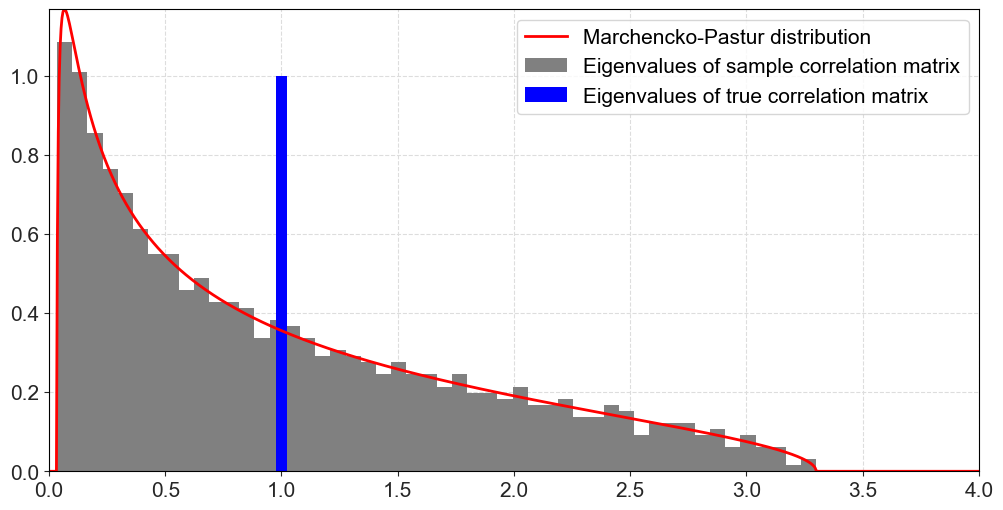

In [37]:
"""
Calculate covariance matrix (same as correlation matrix in this case) 
"""

corr_matrix = np.corrcoef(simulated_data.T)
eig_vals, eig_vectors = np.linalg.eig(corr_matrix)

"""
Plot the density of the eigenvalues
"""

x = np.linspace(0.0, 4.0, 1000)
dv = marchencko_pastur_density(x, 1.0,  n/t)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x, dv, color="red", label="Marchencko-Pastur distribution")
plt.hist(eig_vals, bins=50, color="gray", density=True, label="Eigenvalues of sample correlation matrix"); 
plt.hist(true_eigenvalues[0], bins=1, color="blue", rwidth=0.05, density=True, label='Eigenvalues of true correlation matrix')
plt.legend();

When observing a high dimensional data set, we can think of eigenvalues $\lambda \in [\lambda_-, \lambda_+]$ as consistent with random behaviour and eigenvalues $\lambda \notin [\lambda_-, \lambda_+]$ as consistent with non-random behaviour. We may therefore associate $\lambda \in [0, \lambda_+]$ with noise. 

Below we see if we can recover the true number of signals. 

In [38]:
"""
Code adapted from Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"
"""

def fit_kde(eigenvalues, kernel="gaussian", bandwidth=0.01, x=None):
     
    if len(eigenvalues.shape) == 1: eigenvalues = eigenvalues.reshape(-1, 1)
    
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(eigenvalues)
    
    if x is None:
        x = np.unique(eigenvalues)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    
    log_prob = kde.score_samples(x)
    return np.exp(log_prob).flatten()

def simulate_random_cov_mat(num_var, num_factors):
    
    """
    Simulate a random covariance matrix with some dependence
    """
    
    x = np.random.normal(size=(num_var, num_factors))
    cov_mat = x @ x.T
    cov_mat += np.diag(np.random.uniform(size=num_var))
    
    return cov_mat


def simulate_cov_mat_noise_and_signal(num_var, num_factors,
                                      num_obs, alpha):
    
    cov_mat_noise = np.cov(np.random.normal(size=(num_obs, num_var))
                           , rowvar=False)
    cov_mat_signal = simulate_random_cov_mat(num_var, num_factors)
    cov_mat = alpha * cov_mat_noise + (1-alpha) * cov_mat_signal
    
    return cov_mat

def cov_to_corr_matrix(cov_mat):
    
    vols = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1 # numerical error 
    
    return corr_mat

def corr_to_cov_matrix(corr_mat, vols):
    
    cov_mat = corr_mat * np.outer(vols, vols)
    
    return cov_mat

def fitting_error(sigma, ratio, x, eigenvalues, kernel="gaussian",
                  bandwidth=0.01):
    
    mp_density = marchencko_pastur_density(x, sigma, ratio)

    kde_density = fit_kde(eigenvalues, kernel=kernel, bandwidth=bandwidth, x=x)

    return np.mean(np.square(mp_density - kde_density))

In [39]:
"""
Find the sigma that fits best with the observed eigenvalues
"""
alpha=0.99
num_var = 1000
num_obs = 5000
num_factors = 100 #<- number of true factors / signals

# simulate correlation matrix with some dependence
sim_cov_mat = simulate_cov_mat_noise_and_signal(num_var, num_factors, num_obs, alpha)
sim_corr_mat = cov_to_corr_matrix(sim_cov_mat)

# get eigenvalues and eigenvectors
eig_vals, eig_vectors = np.linalg.eigh(sim_corr_mat)


# fit sigma
x_eval = np.linspace(0.0, 5.0, 10000)
res = optimize.minimize(fitting_error, 0.25,
                        args=(num_var / num_obs, x_eval, eig_vals),
                        bounds=((1e-5, 1 - 1e-5),))
res

C:\Users\johan\AppData\Local\Temp\ipykernel_19840\2566346161.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dv[i] = 1.0 / (2.0 * np.pi * sigma ** 2) * np.sqrt((upper - temp) * (temp - lower)) / (ratio * temp)
C:\Users\johan\AppData\Local\Temp\ipykernel_19840\2566346161.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dv[i] = 1.0 / (2.0 * np.pi * sigma ** 2) * np.sqrt((upper - temp) * (temp - lower)) / (ratio * temp)
C:\Users\johan\AppData\Local\Temp\ipykernel_19840\2566346161.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element fr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.003436519721264787
        x: [ 7.188e-01]
      nit: 9
      jac: [ 5.476e-05]
     nfev: 30
     njev: 15
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [40]:
# calculate max lambda
lambda_max = marchencko_pastur_bounds(res.x[0], num_var / num_obs)[-1]
lambda_max

# number of recovered true factors
np.sum(eig_vals > lambda_max)

100

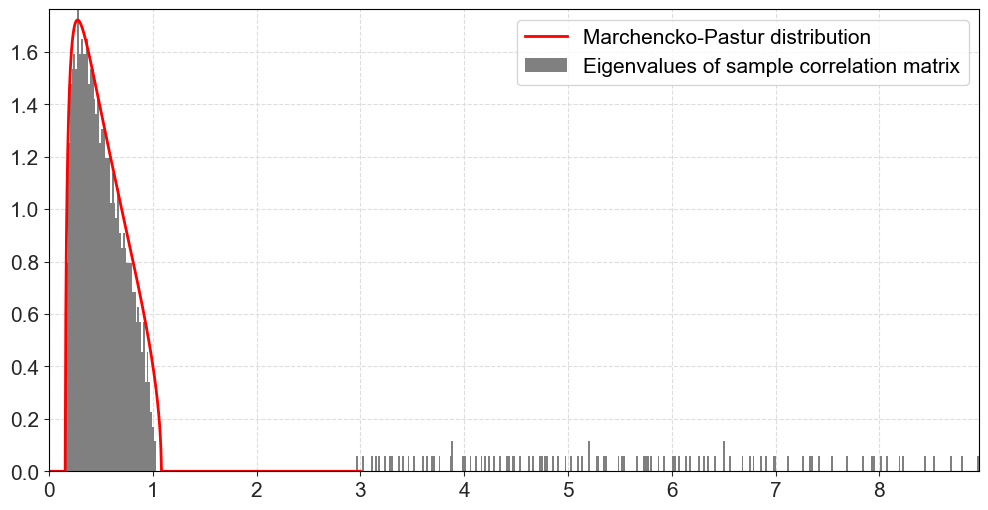

In [41]:
x = np.linspace(0.0, 3.0, 1000)
dv = marchencko_pastur_density(x, res.x[0],  num_var/num_obs)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x, dv, color="red", label="Marchencko-Pastur distribution")
plt.hist(eig_vals, bins=500, color="gray", density=True, label="Eigenvalues of sample correlation matrix"); 

plt.legend();

### Denoising 



__Constant residual eigenvalue method__

This method sets all "random" eigenvectors the corresponding eigenvalue equal to a constant. Let $\{ \lambda \}_{n=1,..., N}$ be the eigenvalues (in descending order) and let $m$ denote the position of the eigenvalue such that $\lambda_m > \lambda_+$ and $\lambda_{m+1} \leq \lambda_+$. Then for $i = m + 1, ...., N$ we set 

$$
\lambda_i = \frac{1}{N-i} \sum_{j=m + 1}^M \lambda_j
$$

This will preserve the trace of the correlation matrix. 

The [eigenvector decompostion](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) tells us that we can write the correlation matrix as

$$
\mathbf{C} = \mathbf{V} \boldsymbol{\Lambda} \mathbf{V}^\top = \mathbf{V} \boldsymbol{\Lambda} \mathbf{V}^{-1}
$$

with $\mathbf{V}$ being the eigenvectors and $\boldsymbol{\Lambda}$ being a diagonal matrix of the eigenvalues.  The last equality holds since $\mathbf{V}$ is an [orthogonal matrix](https://en.wikipedia.org/wiki/Orthogonal_matrix). 

We define the denoised correlation matrix as 

$$
\tilde{\mathbf{C}}_{denoised} = \mathbf{V} \tilde{\boldsymbol{\Lambda}} \mathbf{V}^\top \\
\mathbf{C}_{denoised} = \tilde{\mathbf{C}}_{denoised} \left[ \left(\text{diag} \left[\tilde{\mathbf{C}}_{denoised} \right]^{1/2} \right)  \left(\text{diag} \left[\tilde{\mathbf{C}}_{denoised} \right]^{1/2} \right)^\top \right]^{-1}
$$

where $\tilde{\boldsymbol{\Lambda}}$ contains the corrected eigenvalues. The last line ensures that all the diagonal elements equal one. 

In [42]:
def crem_denoised_corr_mat(eigenvalues: np.ndarray,
                           eigenvectors: np.ndarray,
                           num_factors: int) -> np.ndarray:

    """
    Denoises correlation matrix by fixing random eigenvalues

    Parameters
    ----------
    eigenvalues:
        Sorted eigenvalues.
    eigenvectors:
        Sorted eigenvectors
    num_factors:
        Number of factors.

    Returns
    -------
    np.ndarray
        Denoised correlation matrix.

    """

    eig_vals = eigenvalues.copy()
    eig_vals[num_factors:] = eig_vals[num_factors:].sum() / float(len(eig_vals) - num_factors)
    eig_vals = np.diag(eig_vals)

    corr_mat = eigenvectors @ eig_vals @ eigenvectors.T
    corr_mat = cov_to_corr_matrix(corr_mat)

    return corr_mat


In [43]:
# sort eigen vals
indices = eig_vals.argsort()[::-1]
eig_vals_sorted = eig_vals[indices]
eig_vectors_sorted = eig_vectors[:, indices]

In [44]:
denoised_corr = crem_denoised_corr_mat(eig_vals_sorted, eig_vectors_sorted, 100)
denoised_eig_vals, denoised_eig_vec = np.linalg.eig(denoised_corr)

In [45]:
# sort eigen vals
indices = denoised_eig_vals.argsort()[::-1]
denoised_eig_vals_sorted = denoised_eig_vals[indices]
denoised_eig_vec_sorted = denoised_eig_vec[:, indices]

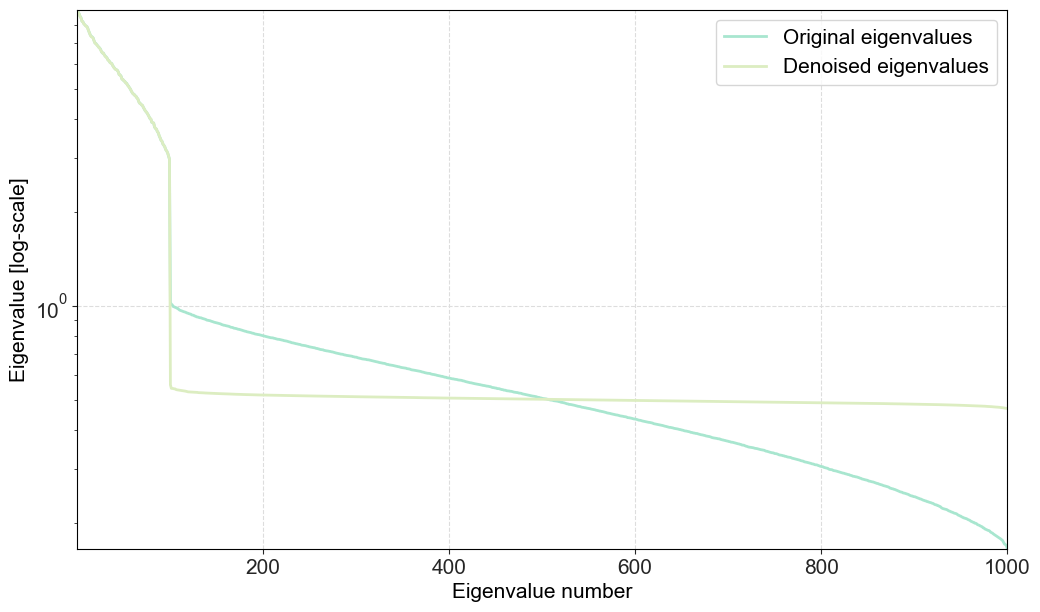

In [46]:
x_vals = np.arange(1.0, len(eig_vals) + 1)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_vals, eig_vals_sorted, label="Original eigenvalues"); 
ax.plot(x_vals, denoised_eig_vals_sorted, label="Denoised eigenvalues"); 
plt.yscale('log')
ax.legend();
ax.set_xlabel("Eigenvalue number");
ax.set_ylabel("Eigenvalue [log-scale]");

### __Targeted shrinkage__

The method applies shrinkage strictly to the random eigenvectors

$$
\mathbf{C}_{denoised} = \mathbf{V}_L \boldsymbol{\Lambda}_L \mathbf{V}_L^\top + \alpha \mathbf{V}_R \boldsymbol{\Lambda}_R \mathbf{V}_R^\top + (1-\alpha) \text{diag} \left[ \mathbf{V}_R \boldsymbol{\Lambda}_R \mathbf{V}^\top_R \right] 
$$

where $\mathbf{V}_L$ and $ \boldsymbol{\Lambda}_L$ are associated with the eigenvalues $\lambda > \lambda_{+}$ and $\mathbf{V}_R$ and $ \boldsymbol{\Lambda}_R$ are associated with the eigenvalues $\lambda \leq \lambda_{+}$. $\alpha$ regulates the amount of shrinkage ($\alpha=0$ for total shrinkage). 

In [47]:
def tsm_denoised_corr_mat(eigenvalues: np.ndarray, eigenvectors: np.ndarray, num_factors: int,
                          alpha: float = 0.0) -> np.ndarray:

    """
    Denoises correlation matrix by shrinkage on eigenvectors

    Target shrinkage method.

    Parameters
    ----------
    eigenvalues:
        Sorted eigenvalues.
    eigenvectors:
        Sorted eigenvectors
    num_factors:
        Number of factors.
    alpha:
        Weight.

    Returns
    -------
    np.ndarray
        Denoised correlation matrix.

    """

    eig_vals_l = np.diag(eigenvalues[:num_factors])
    eig_vals_r = np.diag(eigenvalues[num_factors:])

    eig_vecs_l = eigenvectors[:, :num_factors]
    eig_vecs_r = eigenvectors[:, num_factors:]

    part1 = eig_vecs_l @ eig_vals_l @ eig_vecs_l.T
    part2 = eig_vecs_r @ eig_vals_r @ eig_vecs_r.T
    part3 = np.diag(np.diag(part2))

    corr_mat = part1 + alpha * part2 + (1 - alpha) * part3

    return corr_mat

In [48]:
denoised_corr = tsm_denoised_corr_mat(eig_vals_sorted, eig_vectors_sorted, 100, alpha=0.0)
denoised_eig_vals, denoised_eig_vec = np.linalg.eig(denoised_corr)

indices = denoised_eig_vals.argsort()[::-1]
denoised_eig_vals_sorted = denoised_eig_vals[indices]
denoised_eig_vec_sorted = denoised_eig_vec[:, indices]

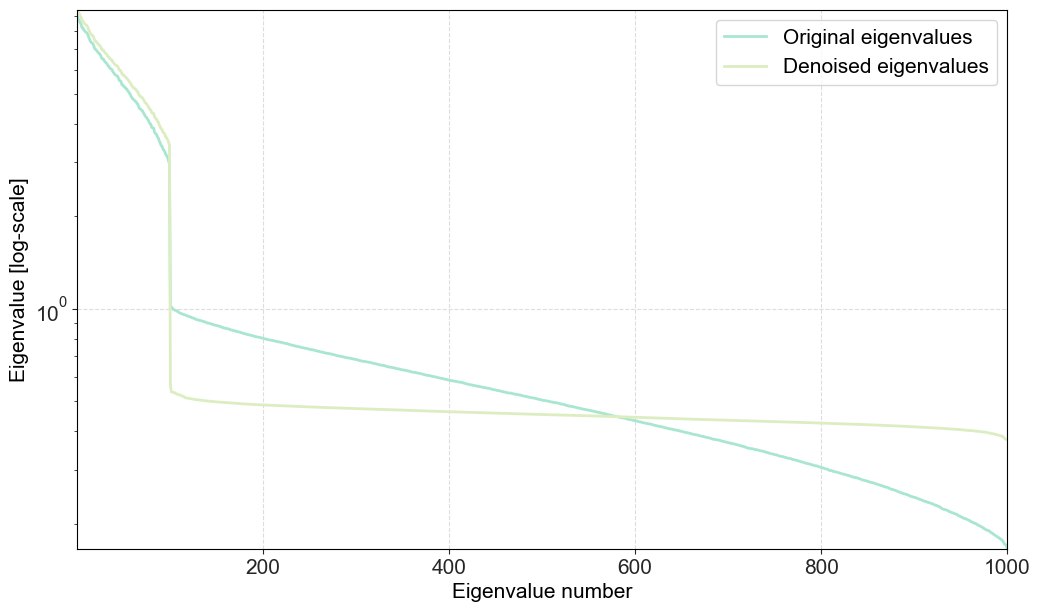

In [49]:
x_vals = np.arange(1.0, len(eig_vals) + 1)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(x_vals, eig_vals_sorted, label="Original eigenvalues"); 
ax.plot(x_vals, denoised_eig_vals_sorted, label="Denoised eigenvalues"); 
plt.yscale('log')
ax.legend();
ax.set_xlabel("Eigenvalue number");
ax.set_ylabel("Eigenvalue [log-scale]");

### Detoning

In financial markets, the "market" component is often the dominant factor. We can think of it as characterized by the first eigenvector with loadings $\mathbf{V}_{n, 1} \approx 1 / \sqrt{N}$. The market component will affect every item of the covariance matrix why it sometimes make sense to remove the market component if we want a closer look at the remaining covariance structure. This is the similar to beta-adjusted returns in regression analysis. 

We can define the detoned correlation matrix as 

$$
\tilde{\mathbf{C}}_{detoned} = \mathbf{C} - \mathbf{V}_M \boldsymbol{\Lambda}_M \mathbf{V}_M^\top = \mathbf{V}_D \boldsymbol{\Lambda}_D \mathbf{V}_D^\top\\
\mathbf{C}_{detoned} = \tilde{\mathbf{C}}_{detoned} \left[ \left(\text{diag} \left[\tilde{\mathbf{C}}_{detoned} \right]^{1/2} \right)  \left(\text{diag} \left[\tilde{\mathbf{C}}_{detoned} \right]^{1/2} \right)^\top \right]^{-1}
$$



In [50]:
def calculate_detoned_corr_mat(eigenvalues, eigenvectors, num_mkt_factors=1):
    
    """
    Eigenvalues and eigenvectors are assumed sorted 
    
    """
    
    eig_vec_non_mkt = eigenvectors[:, num_mkt_factors:]
    
    corr = eig_vec_non_mkt @ np.diag(eigenvalues[num_mkt_factors:]) @ eig_vec_non_mkt.T 
    corr = cov_to_corr_matrix(corr)
    
    return corr

In [51]:
detoned_corr_mat = calculate_detoned_corr_mat(denoised_eig_vals_sorted, denoised_eig_vec_sorted, num_mkt_factors=20)
detoned_corr_mat

array([[ 1.        , -0.1203334 ,  0.00354352, ..., -0.02731327,
        -0.04446609,  0.05696967],
       [-0.1203334 ,  1.        , -0.00917833, ..., -0.01556492,
        -0.01194838, -0.12882415],
       [ 0.00354352, -0.00917833,  1.        , ...,  0.0265172 ,
        -0.06713564, -0.02342353],
       ...,
       [-0.02731327, -0.01556492,  0.0265172 , ...,  1.        ,
         0.00754652,  0.07914099],
       [-0.04446609, -0.01194838, -0.06713564, ...,  0.00754652,
         1.        ,  0.03621741],
       [ 0.05696967, -0.12882415, -0.02342353, ...,  0.07914099,
         0.03621741,  1.        ]])

## Instability caused by signal

Consider the $2 \times 2$ correlation matrix 

$$
\mathbf{C} = \begin{pmatrix} 1 & \rho \\
\rho & 1\end{pmatrix}
$$

which has the eigenvalues $1 + \rho$ and $1 - \rho$. Thus, if we increase the correlation one eigenvalue increase while the other will decrease. 

The inverse of the correlation matrix is given by 

$$
\mathbf{C}^{-1} = \frac{1}{1 - \rho^2} \begin{pmatrix} 1 & -\rho \\
-\rho & 1\end{pmatrix}
$$

with eigenvalues $\frac{1}{1  + \rho}$ and $\frac{1}{1  - \rho}$. Thus, when the correlation comes close to one in absolute terms one of the eigenvalues will descrease to zero while the other one will explode. The determinante of $\mathbf{C}$ ($1 - \rho^2$) will go to zero when the correlation increases in absolute terms causing the inverse of the correlation matrix to explode.  

This will generally hold true. Besides the simply case of the identity correlation matrix, some variables have higher correlation among each other leading to both large and small eigenvalues in the correlation matrix and thereby also a problematic inverse of the correlation matrix. Since the inverse of the correlation / covariance matrix is important when obtaining optimal portfolios (e.g. think on the analytical formula for the minimum variance portfolio), this can lead to a large sensitivty to estimation error when calculating optimal portfolios. 

# References

## Articles

[Ledoit and Wolf (2004), "A well-conditioned estimator for large-dimensional covariance matrices"](https://www.sciencedirect.com/science/article/pii/S0047259X03000964)

## Books

[Marcos M. Lopéz de Prado (2020), "Machine Learning for Asset Managers"](https://www.amazon.com/Machine-Learning-Managers-Elements-Quantitative/dp/1108792898)
